In [2]:
import sys, os, h5py
import numpy as np
import pandas as pd
from numpy import genfromtxt    
from brainspace.mesh import mesh_elements
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainstat.mesh.data import mesh_smooth
import plot_funcs
import warnings
warnings.filterwarnings("ignore")

### write surface coords and tris in a dict

In [2]:
surf_lh, surf_rh = load_conte69()

lh_coord = np.array(mesh_elements.get_points(surf_lh)).T
rh_coord = np.array(mesh_elements.get_points(surf_rh)).T
lh_tri = np.array(mesh_elements.get_cells(surf_lh))
rh_tri = np.array(mesh_elements.get_cells(surf_rh))

D = {}
D['coord'] = np.concatenate((lh_coord, rh_coord), axis=1)         # (3, 64984)     
D['tri'] = np.concatenate((lh_tri, rh_tri + lh_coord.shape[1]))   # (129960, 3)
D['coord'].shape, D['tri'].shape

((3, 64984), (129960, 3))

### load Glasser labeling file to mask out medial wall

In [3]:
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

mask = labeling != 0 

mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False             # left hem
mymask[np.where(mask == False)[0] + 32492] = False     # right hem

# subfield-isocortex functional connectvity (fc)

### SUB (left)

In [4]:
fname_LSUB = '../data/tout_group/Tvals_cortex709_LSUB.h5'

h = h5py.File((fname_LSUB), 'r')
Tdata_LSUB = np.array(h['data'])
h.close()

Tdata_LSUB = Tdata_LSUB.reshape(Tdata_LSUB.shape[1],)
print(Tdata_LSUB.shape)

(64984,)


In [5]:
# mesh smoothing for visualization
Tsmoo_LSUB = mesh_smooth(Tdata_LSUB.reshape(len(Tdata_LSUB),1).T, D, 3)
Tsmoo_LSUB = Tsmoo_LSUB.reshape(Tsmoo_LSUB.shape[1],)
print(Tsmoo_LSUB.shape)

(64984,)


In [6]:
# thresholding the t-values & masking out values below the threshold 
Tsmoo_LSUB[Tsmoo_LSUB<20] = np.nan
Tsmoo_LSUB[np.where(mymask == False)] = np.nan # medial wall

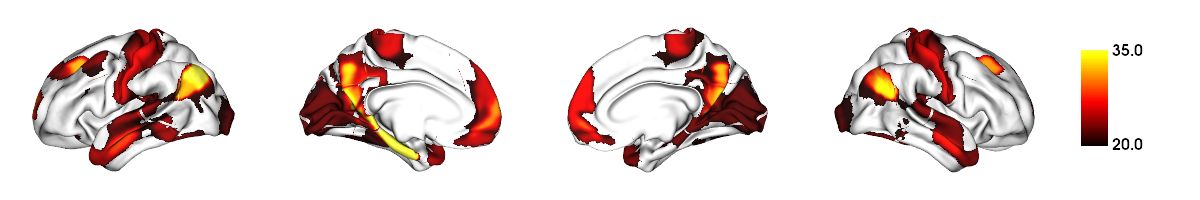

In [7]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo_LSUB,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.hotcolors, 
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/Tvals_cortex_LSUB.png'
                 )

### CA (left)

In [8]:
fname_LCA = '../data/tout_group/Tvals_cortex709_LCA.h5'

h = h5py.File((fname_LCA), 'r')
Tdata_LCA = np.array(h['data'])
h.close()

Tdata_LCA = Tdata_LCA.reshape(Tdata_LCA.shape[1],)

Tsmoo_LCA = mesh_smooth(Tdata_LCA.reshape(len(Tdata_LCA),1).T, D, 3)
Tsmoo_LCA = Tsmoo_LCA.reshape(Tsmoo_LCA.shape[1],)

Tsmoo_LCA[Tsmoo_LCA<20] = np.nan
Tsmoo_LCA[np.where(mymask == False)] = np.nan

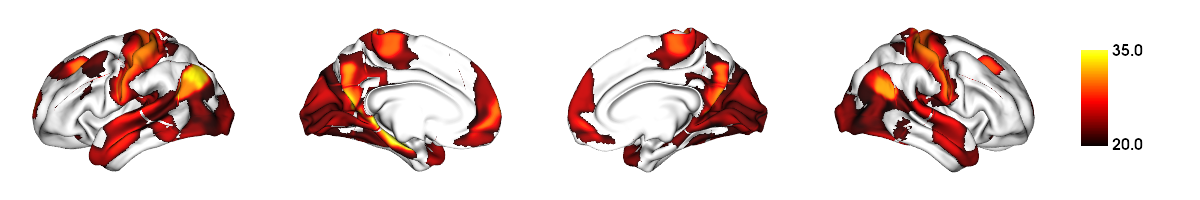

In [9]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo_LCA,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.hotcolors,
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True)

## DG (left)

In [10]:
fname_LDG = '../data/tout_group/Tvals_cortex709_LDG.h5'

h = h5py.File((fname_LDG), 'r')
Tdata_LDG = np.array(h['data'])
h.close()

Tdata_LDG = Tdata_LDG.reshape(Tdata_LDG.shape[1],)

Tsmoo_LDG = mesh_smooth(Tdata_LDG.reshape(len(Tdata_LDG),1).T, D, 3)
Tsmoo_LDG = Tsmoo_LDG.reshape(Tsmoo_LDG.shape[1],)

Tsmoo_LDG[Tsmoo_LDG<20] = np.nan
Tsmoo_LDG[np.where(mymask == False)] = np.nan

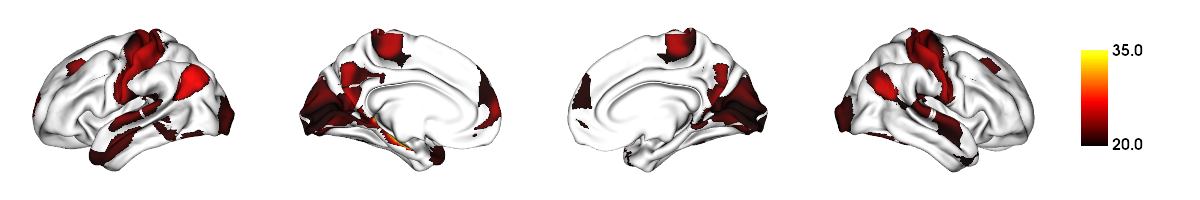

In [11]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo_LDG,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.hotcolors, 
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/Tvals_cortex_LDG.png'
                 )

# Heritability of the subfield-isocortical FC 

In [12]:
# define a function for the FDR correction
def FDR_sofie(p, q):
    # p : 1D np array, vector of p-values
    # q : float, false discovery rate level
    p = np.sort(p)
    V = len(p)
    I = np.arange(1,V+1)

    cVID = 1
    cVN  = (1 / np.arange(1,V+1)).sum()

    pID  = p[np.max(np.where(p <= (I / V*q / cVID)))]
    pN   = np.where(p <= (I / V*q / cVN))
    
    return pID, pN

### we will read out heritability scores from 360 Glasser parcels

In [13]:
tot_node_num = 360
node_str = []
for i in range(1, tot_node_num+1):
    node_str.append(i)
print(len(node_str))

node_str[0], '...', node_str[-1]

360


(1, '...', 360)

## SUB (left)

In [14]:
fLSUB = '../solar/cortex_LSUB/CLSUB_results_herit.txt'

dataLSUB = pd.read_csv(fLSUB, index_col = 0, header = 0)

dataLSUB.index.name = 'node'

dfLSUB = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = dataLSUB.index.get_loc(nodeID)
    iB = dfLSUB.index.get_loc(nodeID)

    dfLSUB.iloc[iB]['H2r'] = dataLSUB.iloc[iA]['H2r']
    dfLSUB.iloc[iB]['rp']  = dataLSUB.iloc[iA]['rp']

HLSUB =  np.array(dfLSUB['H2r'], dtype = 'float')

In [15]:
# FDR correction on p-values
p = np.array(dfLSUB['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])

(0.0445605, 340)

In [16]:
# map H and p values to fsaverage
HLSUB_labeled = map_to_labels(HLSUB, labeling, mask=mymask) 
HLSUB_labeled_smo = mesh_smooth(HLSUB_labeled.reshape(len(HLSUB_labeled),1).T, D, 2)

HLSUB_labeled[np.where(mymask == False)] = np.nan
HLSUB_labeled_smo = HLSUB_labeled_smo.reshape(HLSUB_labeled_smo.shape[1],)
HLSUB_labeled_smo[np.where(mymask == False)] = np.nan

pLSUB_labeled = map_to_labels(p, labeling, mask=mymask) 
pLSUB_labeled[np.where(mymask == False)] = np.nan

print(HLSUB_labeled.shape, pLSUB_labeled.shape)
np.nanmin(HLSUB_labeled), np.nanmax(HLSUB_labeled)

(64984,) (64984,)


(0.0322339, 0.49572879999999997)

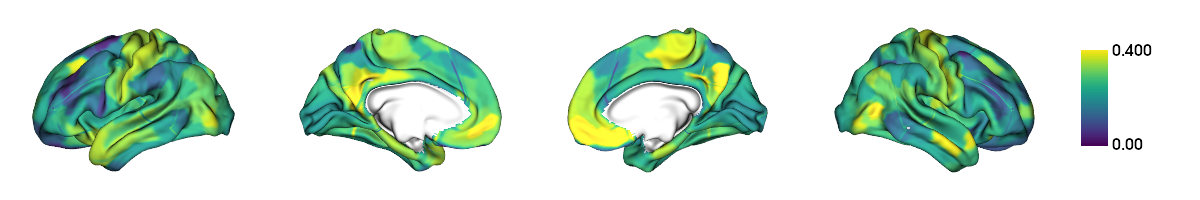

In [17]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HLSUB_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LSUB_smo.png'
                 )

## CA (left)

In [18]:
fLCA = '../solar/cortex_LCA/CLCA_results_herit.txt'

dataLCA = pd.read_csv(fLCA, index_col = 0, header = 0)
dataLCA.index.name = 'node'

dfLCA = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = dataLCA.index.get_loc(nodeID)
    iB = dfLCA.index.get_loc(nodeID)

    dfLCA.iloc[iB]['H2r'] = dataLCA.iloc[iA]['H2r']
    dfLCA.iloc[iB]['rp']  = dataLCA.iloc[iA]['rp']

HLCA =  np.array(dfLCA['H2r'], dtype = 'float')

In [19]:
# FDR correction on p-values
p = np.array(dfLCA['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])

(0.0446693, 351)

In [20]:
HLCA_labeled = map_to_labels(HLCA, labeling, mask=mymask) 
HLCA_labeled_smo = mesh_smooth(HLCA_labeled.reshape(len(HLCA_labeled),1).T, D, 2)
HLCA_labeled_smo = HLCA_labeled_smo.reshape(HLCA_labeled_smo.shape[1],)

HLCA_labeled_smo[np.where(mymask == False)] = np.nan

pLCA_labeled = map_to_labels(p, labeling, mask=mymask) 
pLCA_labeled[np.where(mymask == False)] = np.nan

print(HLCA_labeled.shape, pLCA_labeled.shape)
np.nanmin(HLCA_labeled), np.nanmax(HLCA_labeled)

(64984,) (64984,)


(0.0, 0.5246314000000001)

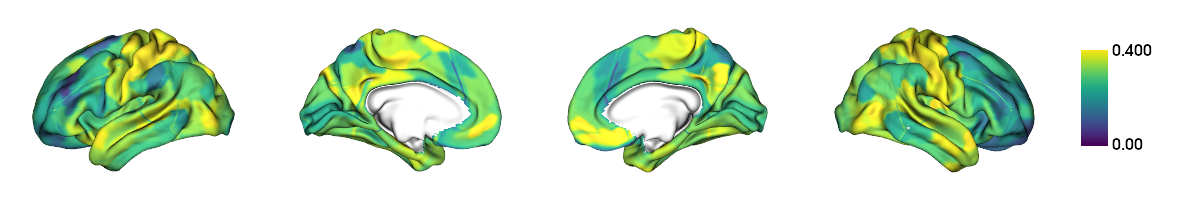

In [21]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HLCA_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LCA_smoo.png'
                 )

## DG (left)

In [22]:
fLDG = '../solar/cortex_LDG/CLDG_results_herit.txt'

dataLDG = pd.read_csv(fLDG, index_col = 0, header = 0)
dataLDG.index.name = 'node'

dfLDG = pd.DataFrame(index = node_str,columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = dataLDG.index.get_loc(nodeID)
    iB = dfLDG.index.get_loc(nodeID)

    dfLDG.iloc[iB]['H2r'] = dataLDG.iloc[iA]['H2r']
    dfLDG.iloc[iB]['rp']  = dataLDG.iloc[iA]['rp']

HLDG =  np.array(dfLDG['H2r'], dtype = 'float')

In [23]:
# FDR correction on p-values
p = np.array(dfLDG['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])

(0.045503800000000004, 358)

In [24]:
HLDG_labeled = map_to_labels(HLDG, labeling, mask=mymask) 
HLDG_labeled_smo = mesh_smooth(HLDG_labeled.reshape(len(HLDG_labeled),1).T, D, 2)
HLDG_labeled_smo = HLDG_labeled_smo.reshape(HLDG_labeled_smo.shape[1],)

HLDG_labeled[np.where(mymask == False)] = np.nan
HLDG_labeled_smo[np.where(mymask == False)] = np.nan

pLDG_labeled = map_to_labels(p, labeling, mask=mymask) 
pLDG_labeled[np.where(mymask == False)] = np.nan

print(HLDG_labeled.shape, pLDG_labeled.shape)
np.nanmin(HLDG_labeled), np.nanmax(HLDG_labeled)

(64984,) (64984,)


(0.0634892, 0.5007803)

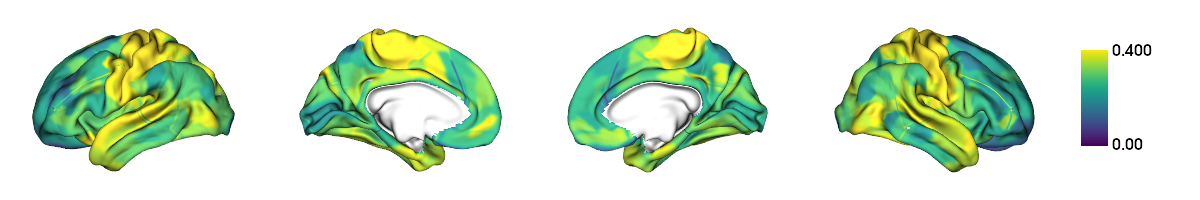

In [25]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HLDG_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LDG_smo.png'
                 )

# Gradients of subfield-isocortical fc

In [26]:
ddir = '../data/tout_group/'

# read-in primary and secongardy gradients (G1 & G2) for individual subfields
h1  = h5py.File(os.path.join(ddir, 'Hmean709connGradients_left.h5'), 'r');

G1_fc_LSUB = np.array(h1['gradients_'][0:1024,0])
G1_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,0])
G1_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,0])

G2_fc_LSUB = np.array(h1['gradients_'][0:1024,1])
G2_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,1])
G2_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,1])


## G1 (fc)

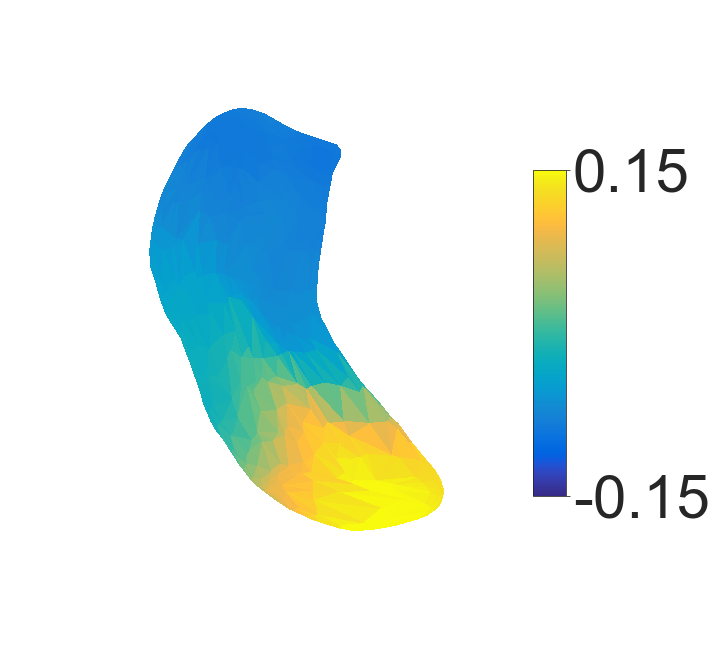

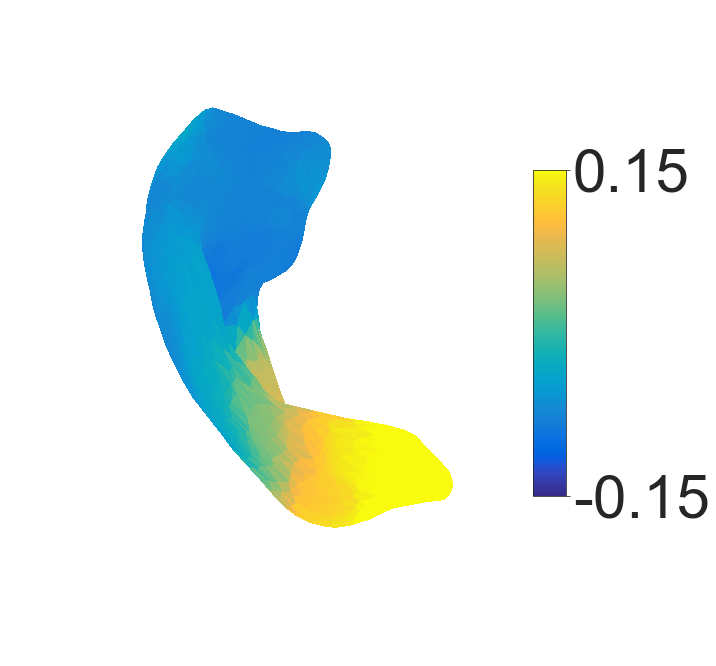

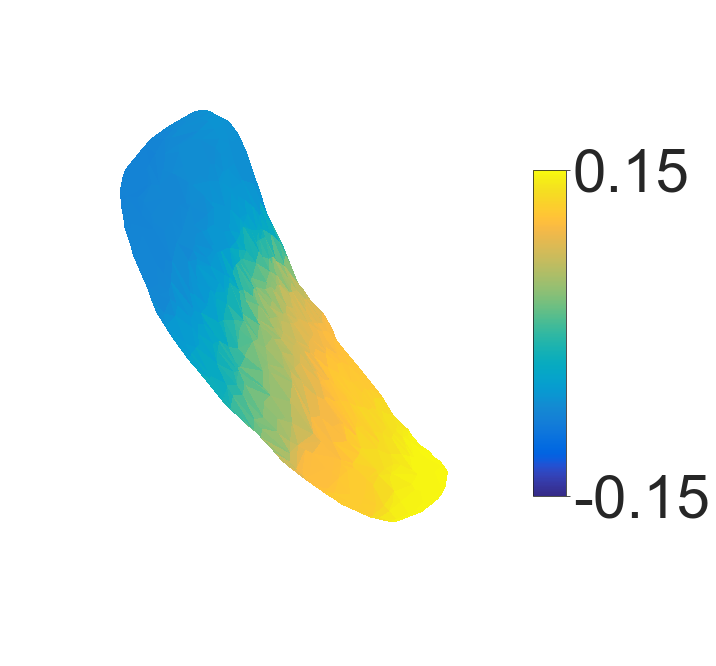

In [27]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G1_fc_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_fc_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)


fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_fc_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)



## G2 (fc)

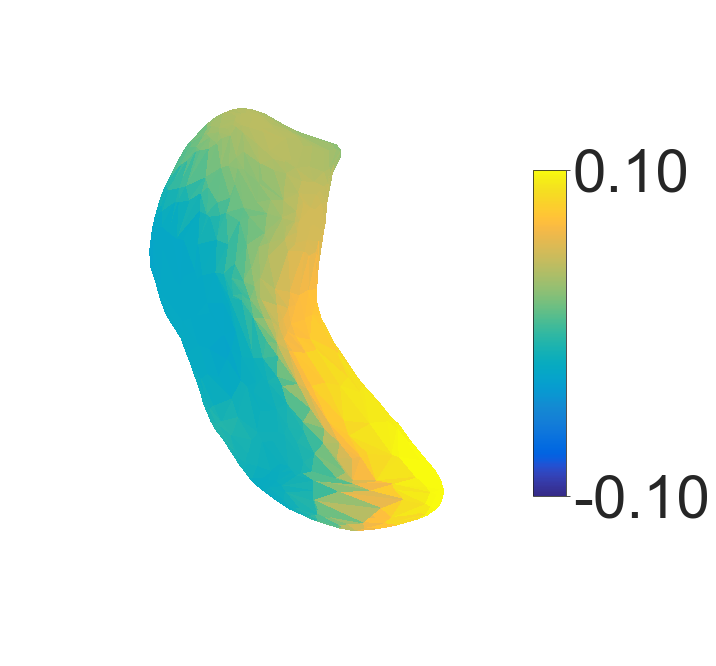

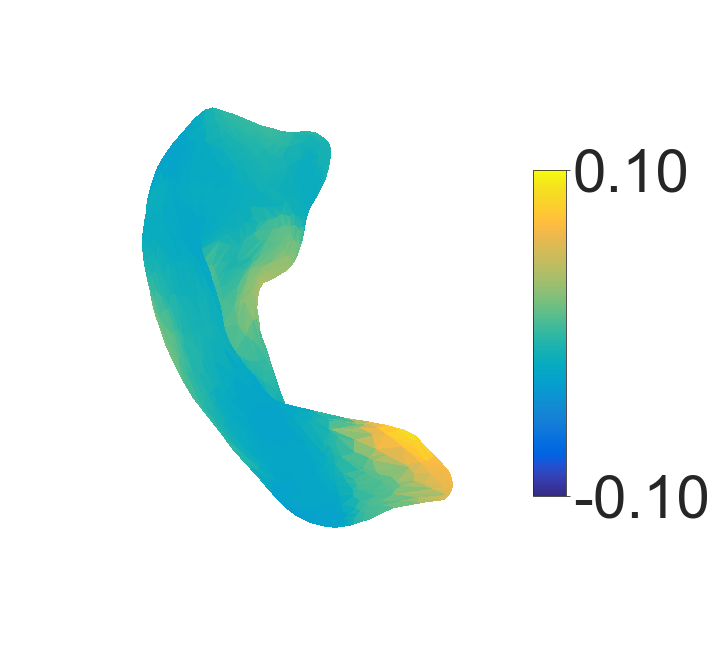

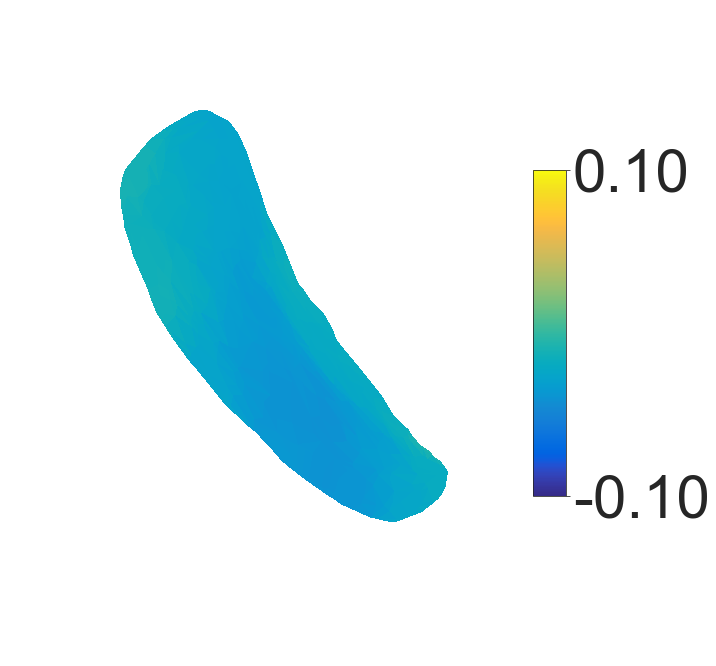

In [28]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G2_fc_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.1, 0.1)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_fc_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.1, 0.1)


fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_fc_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.1, 0.1)


# Heritability of subfield gradients

### heritability of G1 (fc) -> LSUB

In [29]:
# read-in heritability scores from 1024 LSUB vertices
tot_node_num_lsub = 1024
node_str = []
for i in range(1, tot_node_num_lsub+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

1024


(1, '...', 1024)

In [30]:
fnameLSUB = '../solar/msm50_G1_LSUB/G1_LSUB_results_herit.txt'

herit_g1_LSUB = pd.read_csv(fnameLSUB, index_col = 0, header = 0)
herit_g1_LSUB.index.name = 'node'

df_herit_g1_LSUB = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lsub+1):

    iA = herit_g1_LSUB.index.get_loc(nodeID)
    iB = df_herit_g1_LSUB.index.get_loc(nodeID)

    df_herit_g1_LSUB.iloc[iB]['H2r'] = herit_g1_LSUB.iloc[iA]['H2r']
    df_herit_g1_LSUB.iloc[iB]['rp']  = herit_g1_LSUB.iloc[iA]['rp']

sorted_herit_g1_LSUB = np.array(df_herit_g1_LSUB['H2r'], dtype = 'float')

sorted_herit_g1_LSUB.min(), sorted_herit_g1_LSUB.max(), sorted_herit_g1_LSUB.mean()

(0.06361900000000001, 0.29816220000000004, 0.1433508923828125)

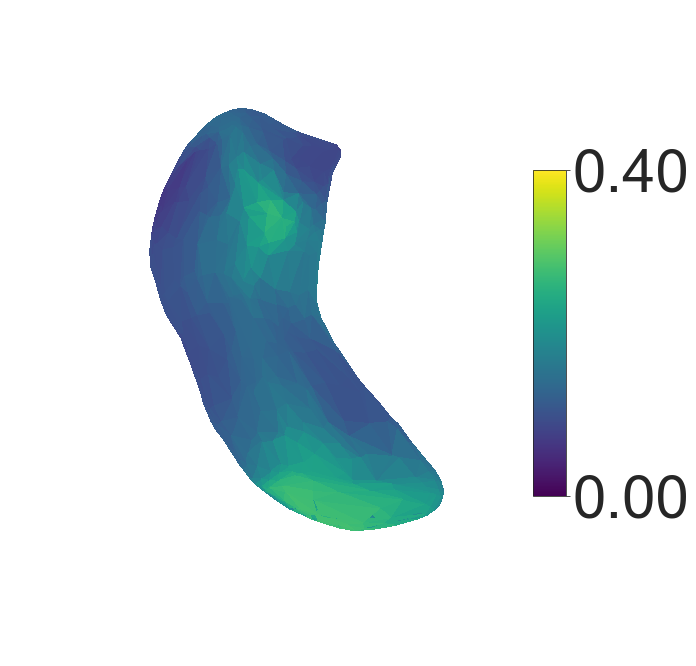

In [31]:
fig  = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, plot_funcs.yLSUB, plot_funcs.zLSUB, plot_funcs.triLSUB, 
                                   sorted_herit_g1_LSUB, 'viridis', 0, 0.40)

### heritability of G2 (fc) -> LSUB

In [32]:
fnameLSUB = '../solar/msm50_G2_LSUB/G2_LSUB_results_herit.txt'

herit_g2_LSUB = pd.read_csv(fnameLSUB, index_col = 0, header = 0)
herit_g2_LSUB.index.name = 'node'

df_herit_g2_LSUB = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lsub+1):

    iA = herit_g2_LSUB.index.get_loc(nodeID)
    iB = df_herit_g2_LSUB.index.get_loc(nodeID)

    df_herit_g2_LSUB.iloc[iB]['H2r'] = herit_g2_LSUB.iloc[iA]['H2r']
    df_herit_g2_LSUB.iloc[iB]['rp']  = herit_g2_LSUB.iloc[iA]['rp']

sorted_herit_g2_LSUB = np.array(df_herit_g2_LSUB['H2r'], dtype = 'float')

sorted_herit_g2_LSUB.min(), sorted_herit_g2_LSUB.max(), sorted_herit_g2_LSUB.mean()

(0.0, 0.17966410000000002, 0.054657052148437496)

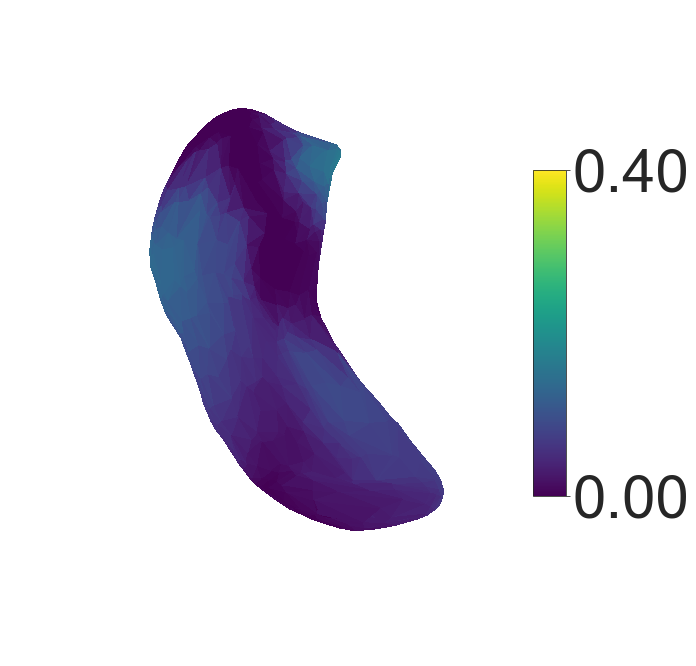

In [33]:
fig  = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, plot_funcs.yLSUB, plot_funcs.zLSUB, plot_funcs.triLSUB, 
                                   sorted_herit_g2_LSUB, 'viridis', 0, 0.40)

### heritability of G1 (fc) -> LCA

In [34]:
tot_node_num_lca = 2048
node_str = []
for i in range(1, tot_node_num_lca+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

2048


(1, '...', 2048)

In [35]:
fnameLCA = '../solar/msm50_G1_LCA/G1_LCA_results_herit.txt'

herit_g1_LCA = pd.read_csv(fnameLCA, index_col = 0, header = 0)
herit_g1_LCA.index.name = 'node'

df_herit_g1_LCA = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lca+1):

    iA = herit_g1_LCA.index.get_loc(nodeID)
    iB = df_herit_g1_LCA.index.get_loc(nodeID)

    df_herit_g1_LCA.iloc[iB]['H2r'] = herit_g1_LCA.iloc[iA]['H2r']
    df_herit_g1_LCA.iloc[iB]['rp']  = herit_g1_LCA.iloc[iA]['rp']

sorted_herit_g1_LCA = np.array(df_herit_g1_LCA['H2r'], dtype = 'float')

sorted_herit_g1_LCA.min(), sorted_herit_g1_LCA.max(), sorted_herit_g1_LCA.mean()

(0.0, 0.2608974, 0.12841948935546876)

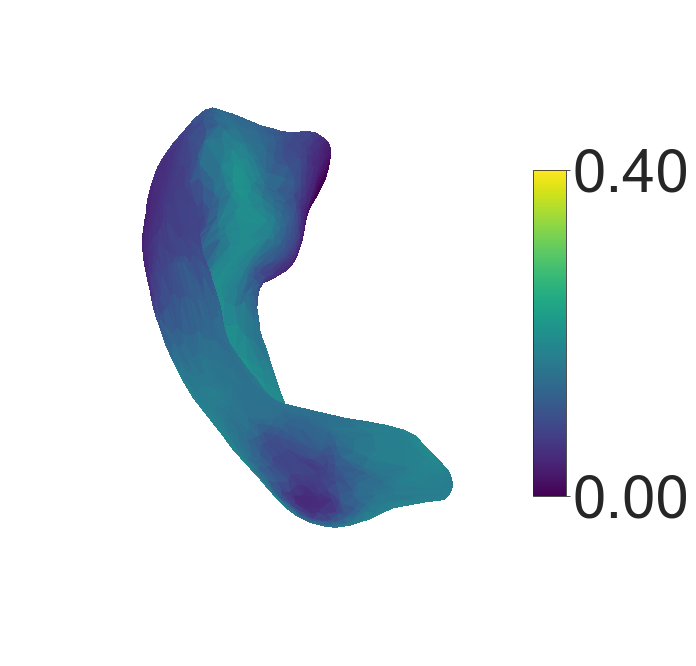

In [36]:
fig  = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, plot_funcs.yLCA, plot_funcs.zLCA, plot_funcs.triLCA, 
                                   sorted_herit_g1_LCA, 'viridis', 0, 0.40)

### heritability of G2 (fc) -> LCA

In [37]:
fnameLCA = '../solar/msm50_G2_LCA/G2_LCA_results_herit.txt'

herit_g2_LCA = pd.read_csv(fnameLCA, index_col = 0, header = 0)
herit_g2_LCA.index.name = 'node'

df_herit_g2_LCA = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lca+1):

    iA = herit_g2_LCA.index.get_loc(nodeID)
    iB = df_herit_g2_LCA.index.get_loc(nodeID)

    df_herit_g2_LCA.iloc[iB]['H2r'] = herit_g2_LCA.iloc[iA]['H2r']
    df_herit_g2_LCA.iloc[iB]['rp']  = herit_g2_LCA.iloc[iA]['rp']

sorted_herit_g2_LCA = np.array(df_herit_g2_LCA['H2r'], dtype = 'float')

np.nanmin(sorted_herit_g2_LCA), np.nanmax(sorted_herit_g2_LCA), np.nanmean(sorted_herit_g2_LCA)

(0.0, 0.312073, 0.07714614504152419)

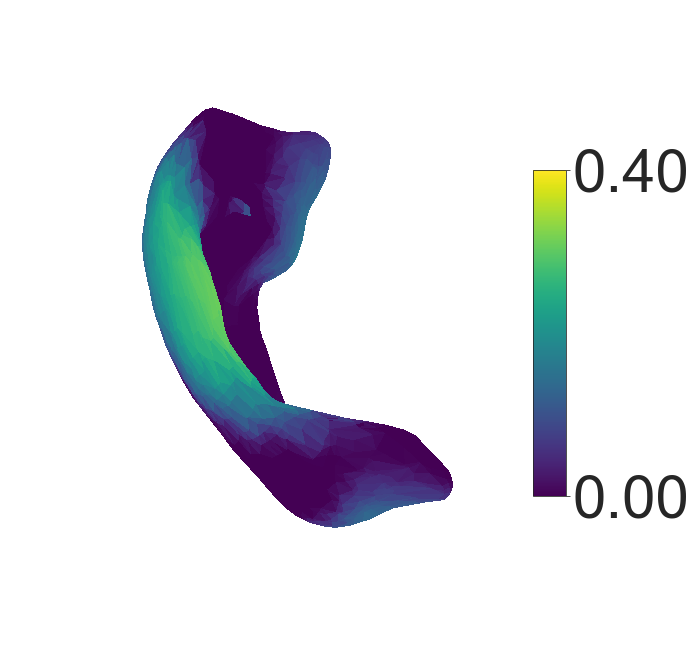

In [38]:
fig  = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, plot_funcs.yLCA, plot_funcs.zLCA, plot_funcs.triLCA, 
                                   sorted_herit_g2_LCA, 'viridis', 0, 0.40)

### heritability of G1 (fc) -> LDG

In [39]:
tot_node_num_lsub = 1024
node_str = []
for i in range(1, tot_node_num_lsub+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

1024


(1, '...', 1024)

In [40]:
fnameLDG = '../solar/msm50_G1_LDG/G1_LDG_results_herit.txt'

herit_g1_LDG = pd.read_csv(fnameLDG, index_col = 0, header = 0)
herit_g1_LDG.index.name = 'node'

df_herit_g1_LDG = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lsub+1):

    iA = herit_g1_LDG.index.get_loc(nodeID)
    iB = df_herit_g1_LDG.index.get_loc(nodeID)

    df_herit_g1_LDG.iloc[iB]['H2r'] = herit_g1_LDG.iloc[iA]['H2r']
    df_herit_g1_LDG.iloc[iB]['rp']  = herit_g1_LDG.iloc[iA]['rp']

sorted_herit_g1_LDG = np.array(df_herit_g1_LDG['H2r'], dtype = 'float')

np.nanmin(sorted_herit_g1_LDG), np.nanmax(sorted_herit_g1_LDG), np.nanmean(sorted_herit_g1_LDG)

(0.0, 0.1562239, 0.04895043202742409)

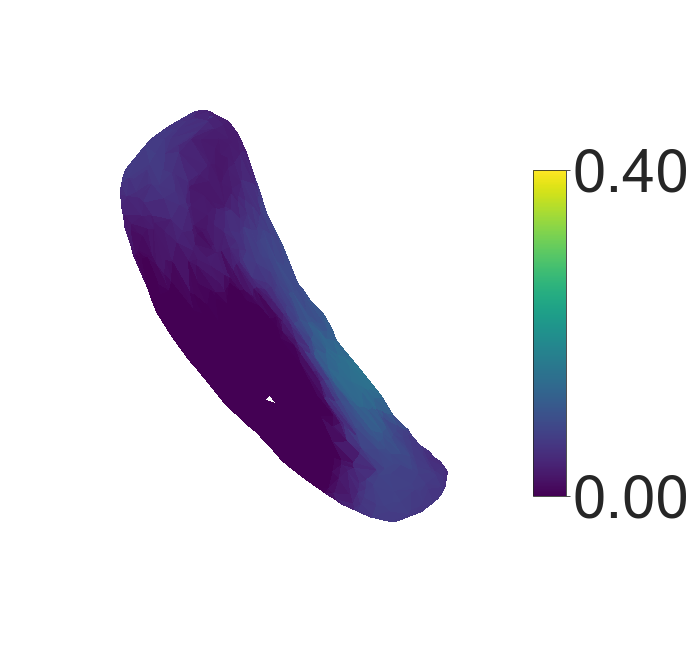

In [41]:
fig  = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, plot_funcs.yLDG, plot_funcs.zLDG, plot_funcs.triLDG, 
                                   sorted_herit_g1_LDG, 'viridis', 0, 0.40)

### heritability of G2 (fc) -> LDG

In [42]:
fnameLDG = '../solar/msm50_G2_LDG/G2_LDG_results_herit.txt'

herit_g2_LDG = pd.read_csv(fnameLDG, index_col = 0, header = 0)
herit_g2_LDG.index.name = 'node'

df_herit_g2_LDG = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lsub+1):

    iA = herit_g2_LDG.index.get_loc(nodeID)
    iB = df_herit_g2_LDG.index.get_loc(nodeID)

    df_herit_g2_LDG.iloc[iB]['H2r'] = herit_g2_LDG.iloc[iA]['H2r']
    df_herit_g2_LDG.iloc[iB]['rp']  = herit_g2_LDG.iloc[iA]['rp']

sorted_herit_g2_LDG = np.array(df_herit_g2_LDG['H2r'], dtype = 'float')

np.nanmin(sorted_herit_g2_LDG), np.nanmax(sorted_herit_g2_LDG), np.nanmean(sorted_herit_g2_LDG)

(0.0, 0.0377356, 0.0004678415520628683)

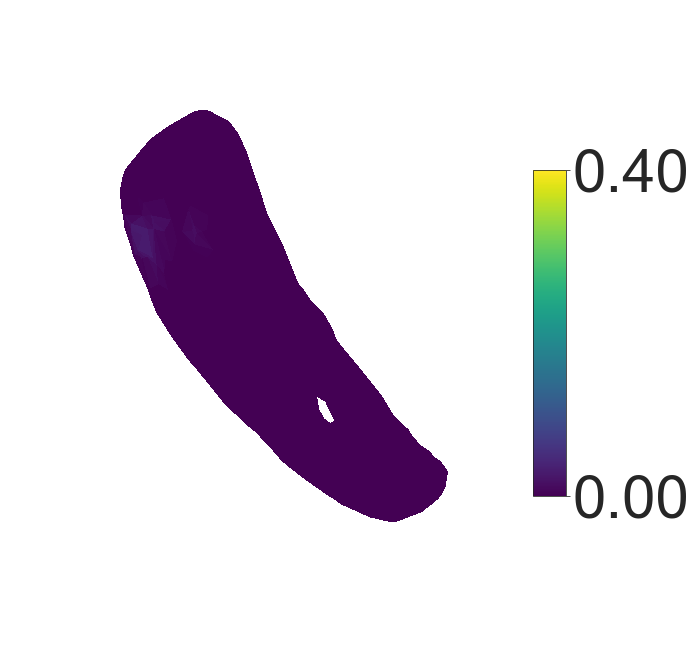

In [43]:
fig  = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, plot_funcs.yLDG, plot_funcs.zLDG, plot_funcs.triLDG, 
                                   sorted_herit_g2_LDG, 'viridis', 0, 0.40)

## Gradients of fc-heritability 

In [44]:
# read-in data: gradients of fc-heritability for subfields
h = h5py.File('../data/tout_group/Hmean709_FC_herit_gradients_left.h5', 'r')

G1_herit_LSUB = np.array(h['gradients'][0:1024,0])
G1_herit_LCA = np.array(h['gradients'][1024:1024+2048,0])
G1_herit_LDG = np.array(h['gradients'][1024+2048:1024+2048+1024,0])

G2_herit_LSUB = np.array(h['gradients'][0:1024,1])
G2_herit_LCA = np.array(h['gradients'][1024:1024+2048,1])
G2_herit_LDG = np.array(h['gradients'][1024+2048:1024+2048+1024,1])


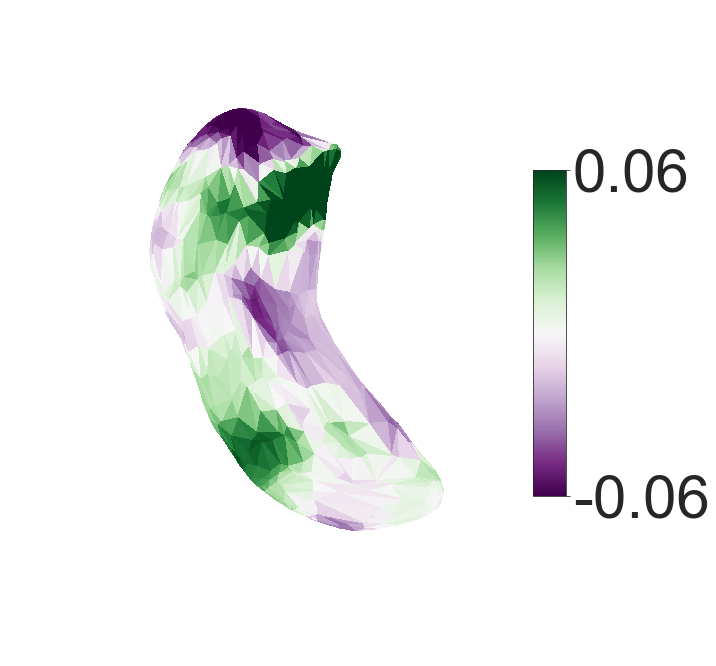

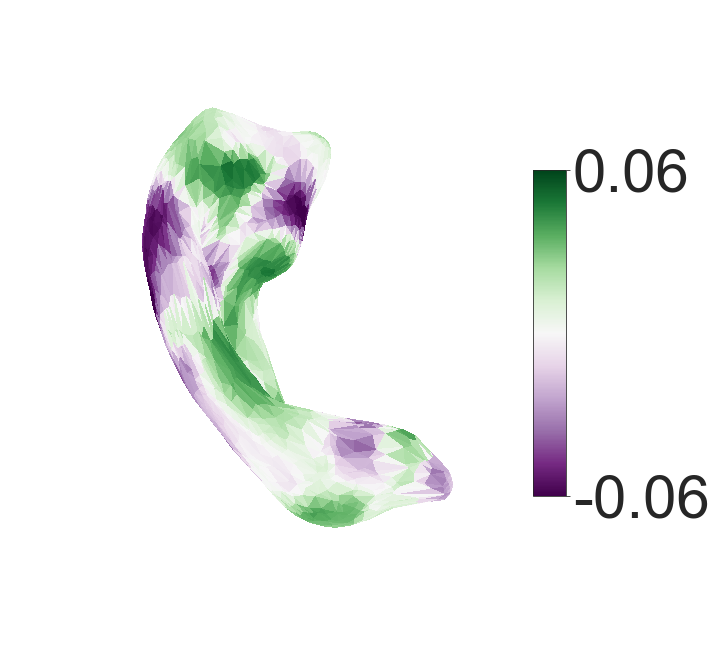

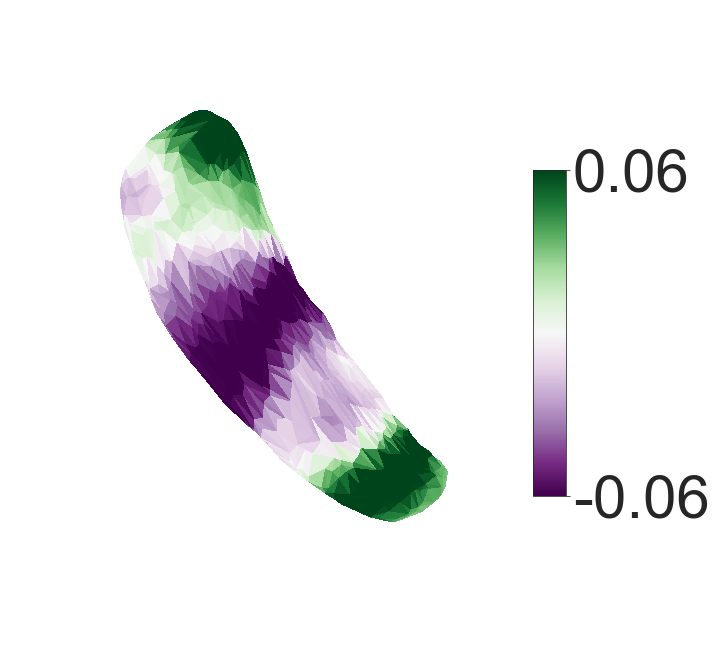

In [45]:
fig = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  G1_herit_LSUB, 'PRGn', -0.06, 0.06)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_herit_LCA, 'PRGn', -0.06, 0.06)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_herit_LDG, 'PRGn', -0.06, 0.06)

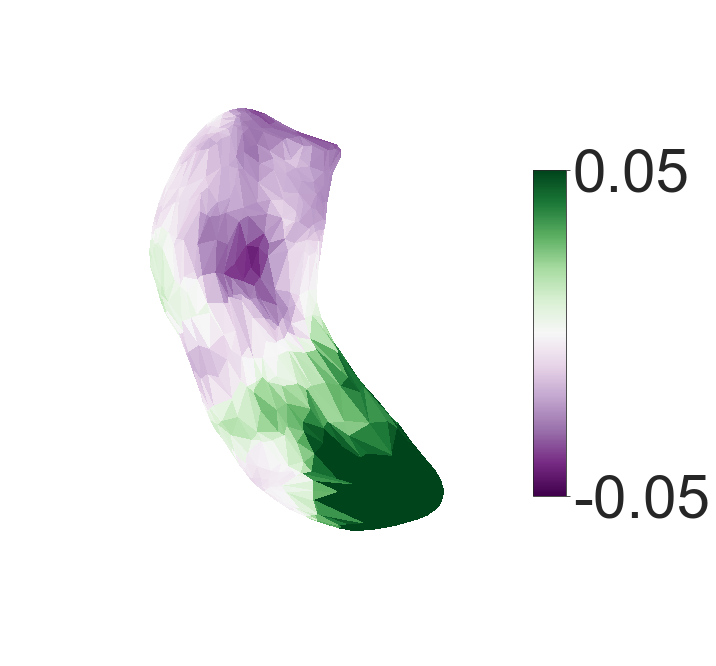

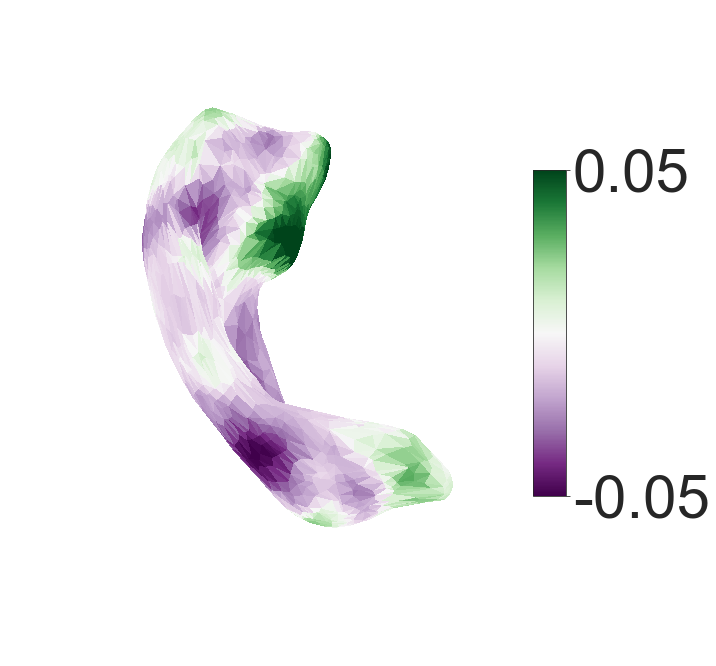

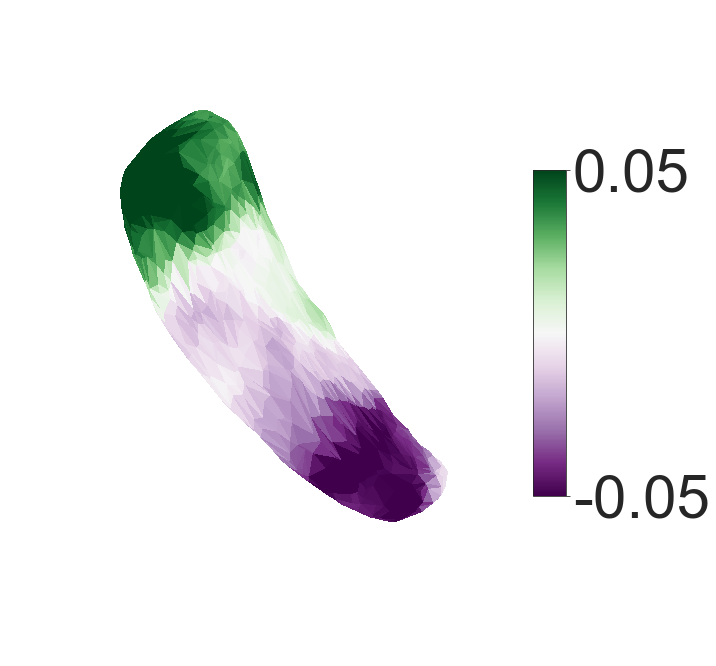

In [46]:
fig = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  G2_herit_LSUB, 'PRGn', -0.05, 0.05)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_herit_LCA, 'PRGn', -0.05, 0.05)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_herit_LDG, 'PRGn', -0.05, 0.05)